In [1]:
# importing all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import itertools
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ProjectCompletedata.csv')
print(dataset)

       Province/State        Country/Region        Lat        Long      Date  \
0                 NaN           Afghanistan  33.939110   67.709953   1/22/20   
1                 NaN               Albania  41.153300   20.168300   1/22/20   
2                 NaN               Algeria  28.033900    1.659600   1/22/20   
3                 NaN               Andorra  42.506300    1.521800   1/22/20   
4                 NaN                Angola -11.202700   17.873900   1/22/20   
...               ...                   ...        ...         ...       ...   
307491            NaN    West Bank and Gaza  31.952200   35.233200  12/20/22   
307492            NaN  Winter Olympics 2022  39.904200  116.407400  12/20/22   
307493            NaN                 Yemen  15.552727   48.516388  12/20/22   
307494            NaN                Zambia -13.133897   27.849332  12/20/22   
307495            NaN              Zimbabwe -19.015438   29.154857  12/20/22   

        Confirmed  Deaths  Recovered  A

In [3]:
#Changing column names
dataset = dataset.rename(columns={"Province/State":"State","Country/Region": "Country"})
dataset["Date"] = pd.to_datetime(dataset["Date"])

* Data Exploration

Here we are doing data analysis using time series, so we are picking only 4 columns Date, Confirmed, Deaths, Recovered and Active cases. Date column is considered as index for the dataset and a new  dataframe is constructed. As some part of the dataset has some week volumes of data, So considered to analyse the data for week, For this I resampled the data by aggregating into weeks.Date columns is converted to date data type and all the date columns will be now for weekly and has a format of 'YYYY-MM-DD'.

In [4]:
#New Data set 
timeseries_df = dataset.filter(["Date",  "Confirmed", "Deaths", "Recovered", "Active"])
timeseries_df = timeseries_df.groupby(timeseries_df["Date"]).sum()
timeseries_df
# Select the proper time period for weekly aggreagation
timeseries_df = timeseries_df['2020-01-22':'2022-12-20'].resample('W').sum()
timeseries_df

,Confirmed,Deaths,Recovered,Active
Date,,,,
2020-01-26,5715,159,199,5192
2020-02-02,61667,1356,1411,56399
2020-02-09,213929,4561,11374,191090
2020-02-16,400406,9588,45755,335130
2020-02-23,534743,15444,120553,387840
...,...,...,...,...
2022-11-27,4482525239,46399851,0,4403277066
2022-12-04,4507127662,46468164,0,4427710946
2022-12-11,4533667067,46545127,0,4454027685


# **DEATH CASES**

Creating a line plot for the full time series of Death Cases. Here plot() function form matplotlib package is used. Tried looking into the trend by plotting the original data alon with other line which is aggregated by the mean for monthly data. So we can find visualisation for line plot with two lines in it. 






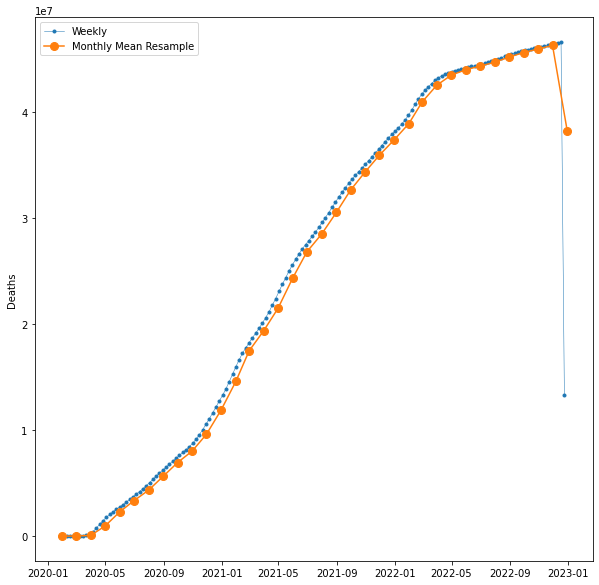

In [5]:
y = timeseries_df['Deaths']
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Deaths')
ax.legend();

The line graph is plotted with Death cases aggregatd for weekly and monthly along with date. If we look into the graph we can observe upward/downward trends in the data along with few anomalies. As there is no data included after December 20th, 2022 we can see a dip at the end of the line.

* Decomposition of the time series: 
The following properties will be observed from data decomposition.
*Trend: It can be seen as a slope with increase or decrease in the data.
* Sesonality: It is observed as patterns with a frequency which is affected by time period.
* Residuals: It is observed as the diffrence between obereved and predicted time series at each at a time t.



In [6]:
# graphs to show seasonal_decompose
def seasonal_decompose_func (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(8,8)
    plt.show()

Calling the function seasonal_decompose() which is created above by passing the time series as an input to the function.

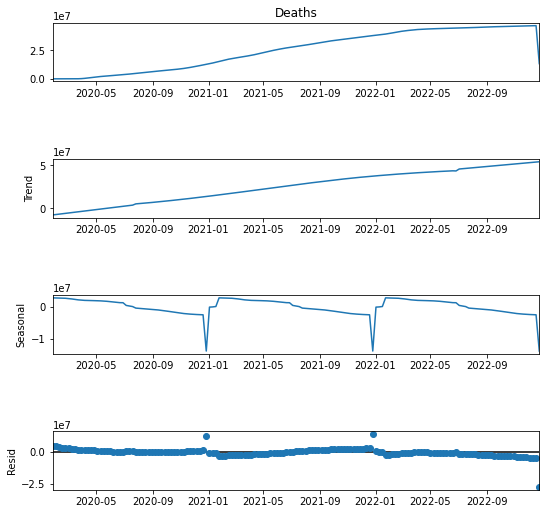

In [7]:
seasonal_decompose_func(y)

From the 4 graphs the first graph indicates the plotting of obserevd series and 2nd graph is for Trend, 3rd is for Sesionality and 4th is for Residuals. Additive model decomposition is chosen for this dataset.From the resultant trend graph it can be observed that there is an upward trend. Also in the sesonal graph we can observe that there is a sesonality for every start of the year.The residuals or the errors are also spread randomly in the Resid graph. By determing these properties of series will be helpful in choosing the time series models.

* **STATIONARITY CHECK**: 
The observations in a stationary time series are not dependent on time.
Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.
When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.


* Rolling statistics test: if time series data is required to be stationary the it should have a constant mean and variance. This indicates the mean and standard deviation or square root of variance are constant with increase in time. The rolling statistics is one of the visualisation method to visulaise the mean and standard deviation of the data.

In [8]:
### plot for Rolling Statistic for testing Stationarity
def stationarity_test(timeseries_data, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries_data).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries_data).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries_data, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std');
    plt.title("Rolling mean and standard deviation")
    ax.legend()

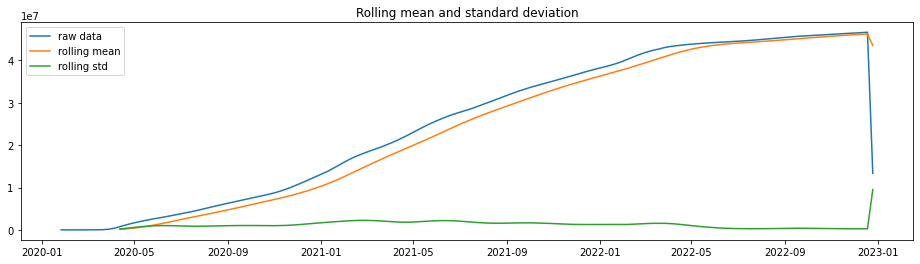

In [9]:
pd.options.display.float_format = '{:.8f}'.format
stationarity_test(y,'raw data')

After plotting the rolling statistics for the Time series data, from the resultant graph it can be observed as the rolling mean is incerasing with the increase in time and rolling standard deviation is constant with time. This indicates that the time series which we are analysing is not stationary.

* Augmented Dickey-Fuller Test:
The main reson behind conducting this test is to determing the stationarity. Here p-value <=0.05 then we can say that the null hypothesis is rejected and the data is stationary. If p-value >0.05 then it failed to reject the hypothesis and the data is not stationary.




In [10]:
# Augmented Dickey-Fuller Test
def ADF_test_func(timeseries_data, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries_data.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [11]:
ADF_test_func(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -1.075
P-value = 0.725
Critical values :
	1%: -3.4744158894942156 - The data is not stationary with 99% confidence
	5%: -2.880878382771059 - The data is not stationary with 95% confidence
	10%: -2.577081275821236 - The data is not stationary with 90% confidence


From the output we can observe that the p-value > 0.05 and also the test statistic when compared to the critical values the test statistic value is greater. So the time series data which we used for analysis is not stationary.

* **Making the data stationary**

* Taking square root of the data: As the data for the death cases are too large in numbers so taking square roo to those values. After doing square root differencing is assigned which computes the differences between the consecutive observations

In [12]:
df_sqrt=np.sqrt(timeseries_df['Deaths'])
df_diff=df_sqrt.diff().dropna()
print(df_diff)

Date
2020-02-02      24.21438507
2020-02-09      30.71127074
2020-02-16      30.38315730
2020-02-23      26.35555774
2020-03-01      16.29281908
                  ...      
2022-11-27       5.08319476
2022-12-04       5.01251065
2022-12-11       5.64279824
2022-12-18       6.15056167
2022-12-25   -3176.51949649
Freq: W-SUN, Name: Deaths, Length: 152, dtype: float64


In [13]:
# Using drop() function to delete last row
df_diff.drop(index=df_diff.index[-1],axis=0,inplace=True)
print(df_diff)
y = df_diff

Date
2020-02-02   24.21438507
2020-02-09   30.71127074
2020-02-16   30.38315730
2020-02-23   26.35555774
2020-03-01   16.29281908
                 ...    
2022-11-20    4.98679705
2022-11-27    5.08319476
2022-12-04    5.01251065
2022-12-11    5.64279824
2022-12-18    6.15056167
Freq: W-SUN, Name: Deaths, Length: 151, dtype: float64


* Detrending: To remove the underlying trend in the time series. Using the stats model we can subtract the trend component from the time series values. Once the subtraction is done then the result is given as argument to test_stationarity() to check the stationarity of time seiries by plots. The detrended result is passed as argument to ADF_test function to test the staionarity.

 > Is the de-trended data stationary ?
Test statistic = -5.276
P-value = 0.000
Critical values :
	1%: -3.4753253063120644 - The data is  stationary with 99% confidence
	5%: -2.881274703275226 - The data is  stationary with 95% confidence
	10%: -2.5772928360116873 - The data is  stationary with 90% confidence


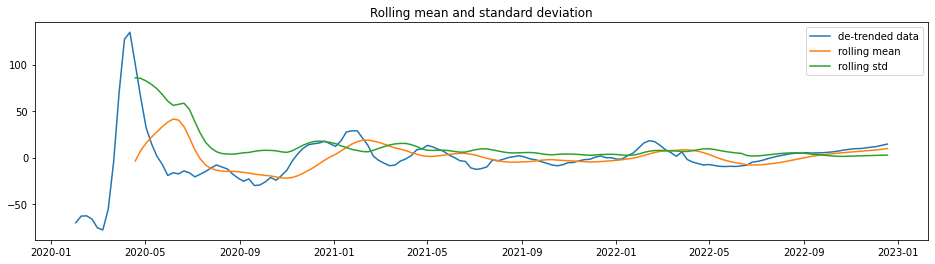

In [14]:
# Detrending
result_add = sm.tsa.seasonal_decompose(y, model='additive', extrapolate_trend='freq')
detrended = y.values - result_add.trend
# rolling statistics test
stationarity_test(detrended,'de-trended data')
#ADF test
ADF_test_func(detrended,'de-trended data')

From the plot we can observe that the mean and statndard deviation are constant with time and the statistcal values output from ADF test are also greater than thecritical values, So the time series had become stationary after removing the trend component.

* Deseasonalising: It removes the underlying seasonaity from the time series. 

 > Is the de-seasonalized data stationary ?
Test statistic = -11.924
P-value = 0.000
Critical values :
	1%: -3.474714913481481 - The data is  stationary with 99% confidence
	5%: -2.881008708148148 - The data is  stationary with 95% confidence
	10%: -2.5771508444444446 - The data is  stationary with 90% confidence


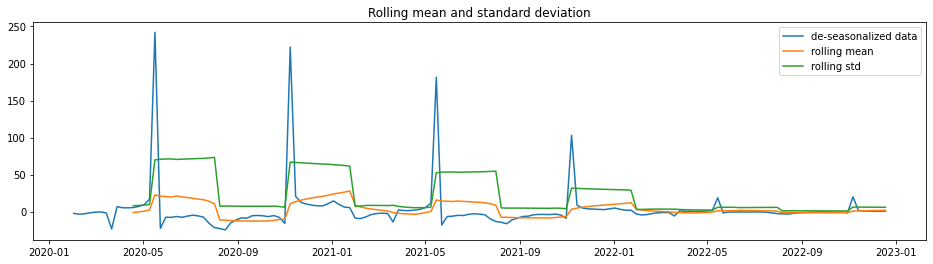

In [15]:
# Deseasonalize
result_add = sm.tsa.seasonal_decompose(y, model='additive', extrapolate_trend='freq')
deseasonlize = y.values / result_add.seasonal
# rolling statistics test
stationarity_test(deseasonlize,'de-seasonalized data')
#ADF test
ADF_test_func(deseasonlize,'de-seasonalized data')

From the plots we can observe that the mean and standard deviation had become constant with time and the test statistic values are also greater than the critical calues. So we can conclude from this that the time series data had become stationary after removing the sesonal component

**ARIMA**:
ARIMA is an Auto Regressive Integrated Moving Average.
It is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values. ARIMA model accepts the non-sesasonal time series. So for this model we are removing the seasonality by taking the deseasonal time series which are computed above.

* Finding order of differencing(d) in ARIMA model: The purpose of differencing it to make the time series stationary.

But we need to be careful to not over-difference the series. Because, an over differenced series may still be non-stationary, which in turn will affect the model parameters.

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing.



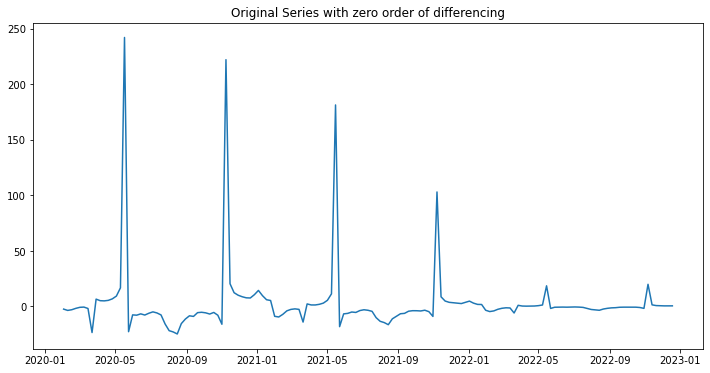

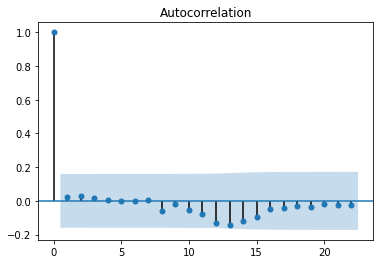

In [16]:
# Original Series
y_deseasonal = deseasonlize
plt.figure(figsize=(12, 6))
plt.plot(y_deseasonal)
plt.title('Original Series with zero order of differencing')
acf0 = plot_acf(y_deseasonal)

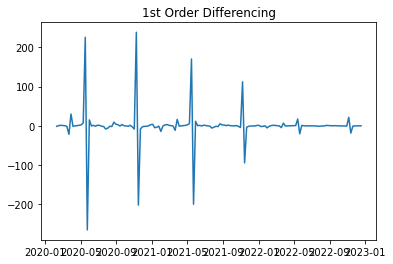

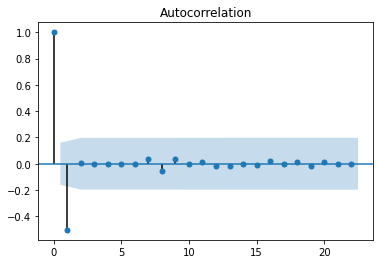

In [17]:
# 1st order Differencing
plt.plot(y_deseasonal.diff()); 
plt.title('1st Order Differencing')
acf1 = plot_acf(y_deseasonal.diff().dropna())


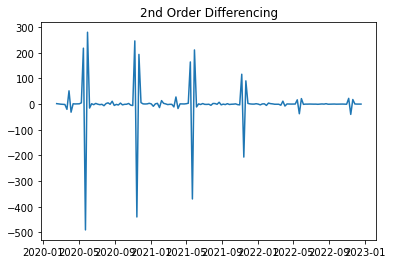

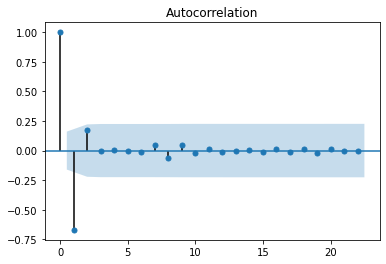

In [18]:
# 2nd order Differencing
plt.plot(y_deseasonal.diff().diff()); 
plt.title('2nd Order Differencing')
acf2 = plot_acf(y_deseasonal.diff().diff().dropna())

From the resultant plots we can observe that the ACF plot reaches to 0 at the zero order difference itself. So we are considering d value which is orderof diffrencing as d = 0 for this time series.

* Deternming AR(p)

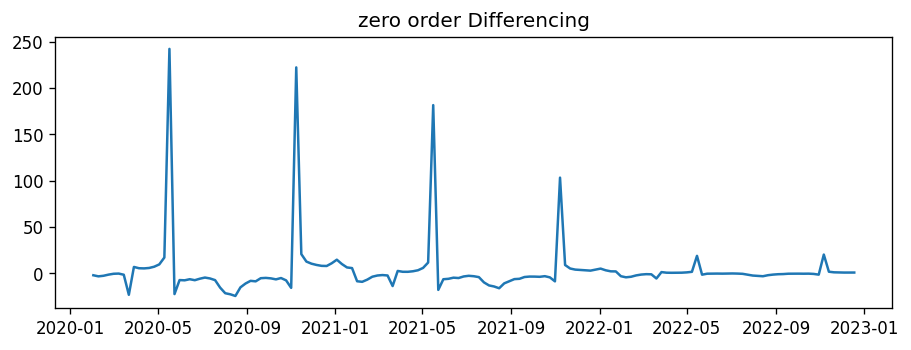

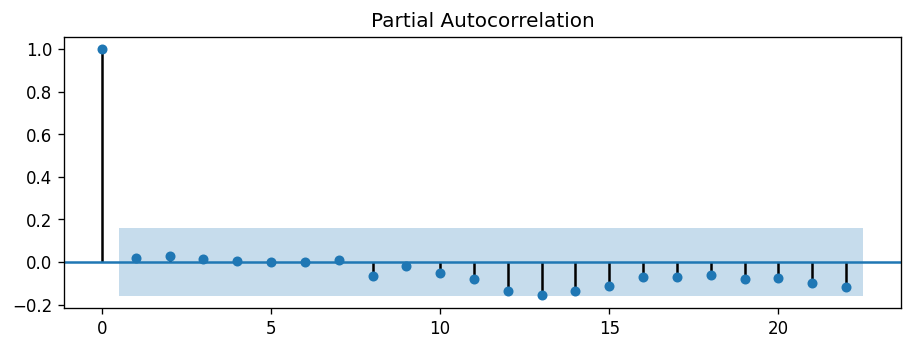

In [19]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

plt.plot(y_deseasonal); 
plt.title('zero order Differencing')
pacf = plot_pacf(y_deseasonal.dropna())

* Determining MA(q)

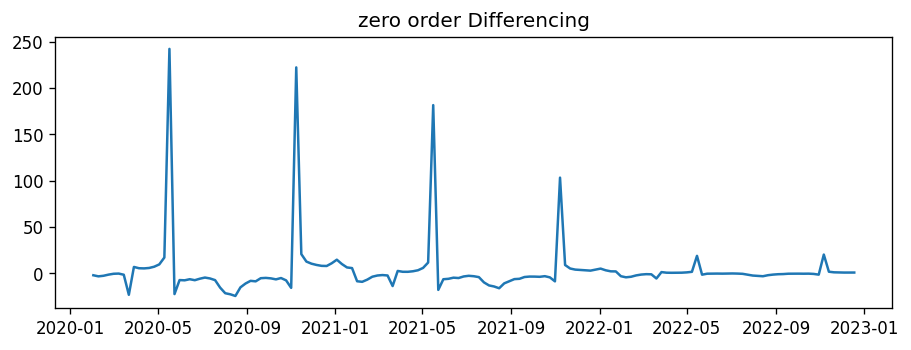

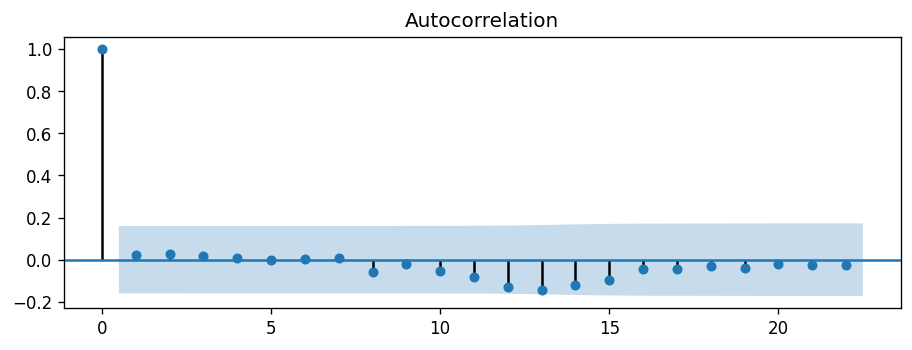

In [20]:
plt.plot(y_deseasonal); 
plt.title('zero order Differencing')
acf = plot_acf(y_deseasonal.dropna())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


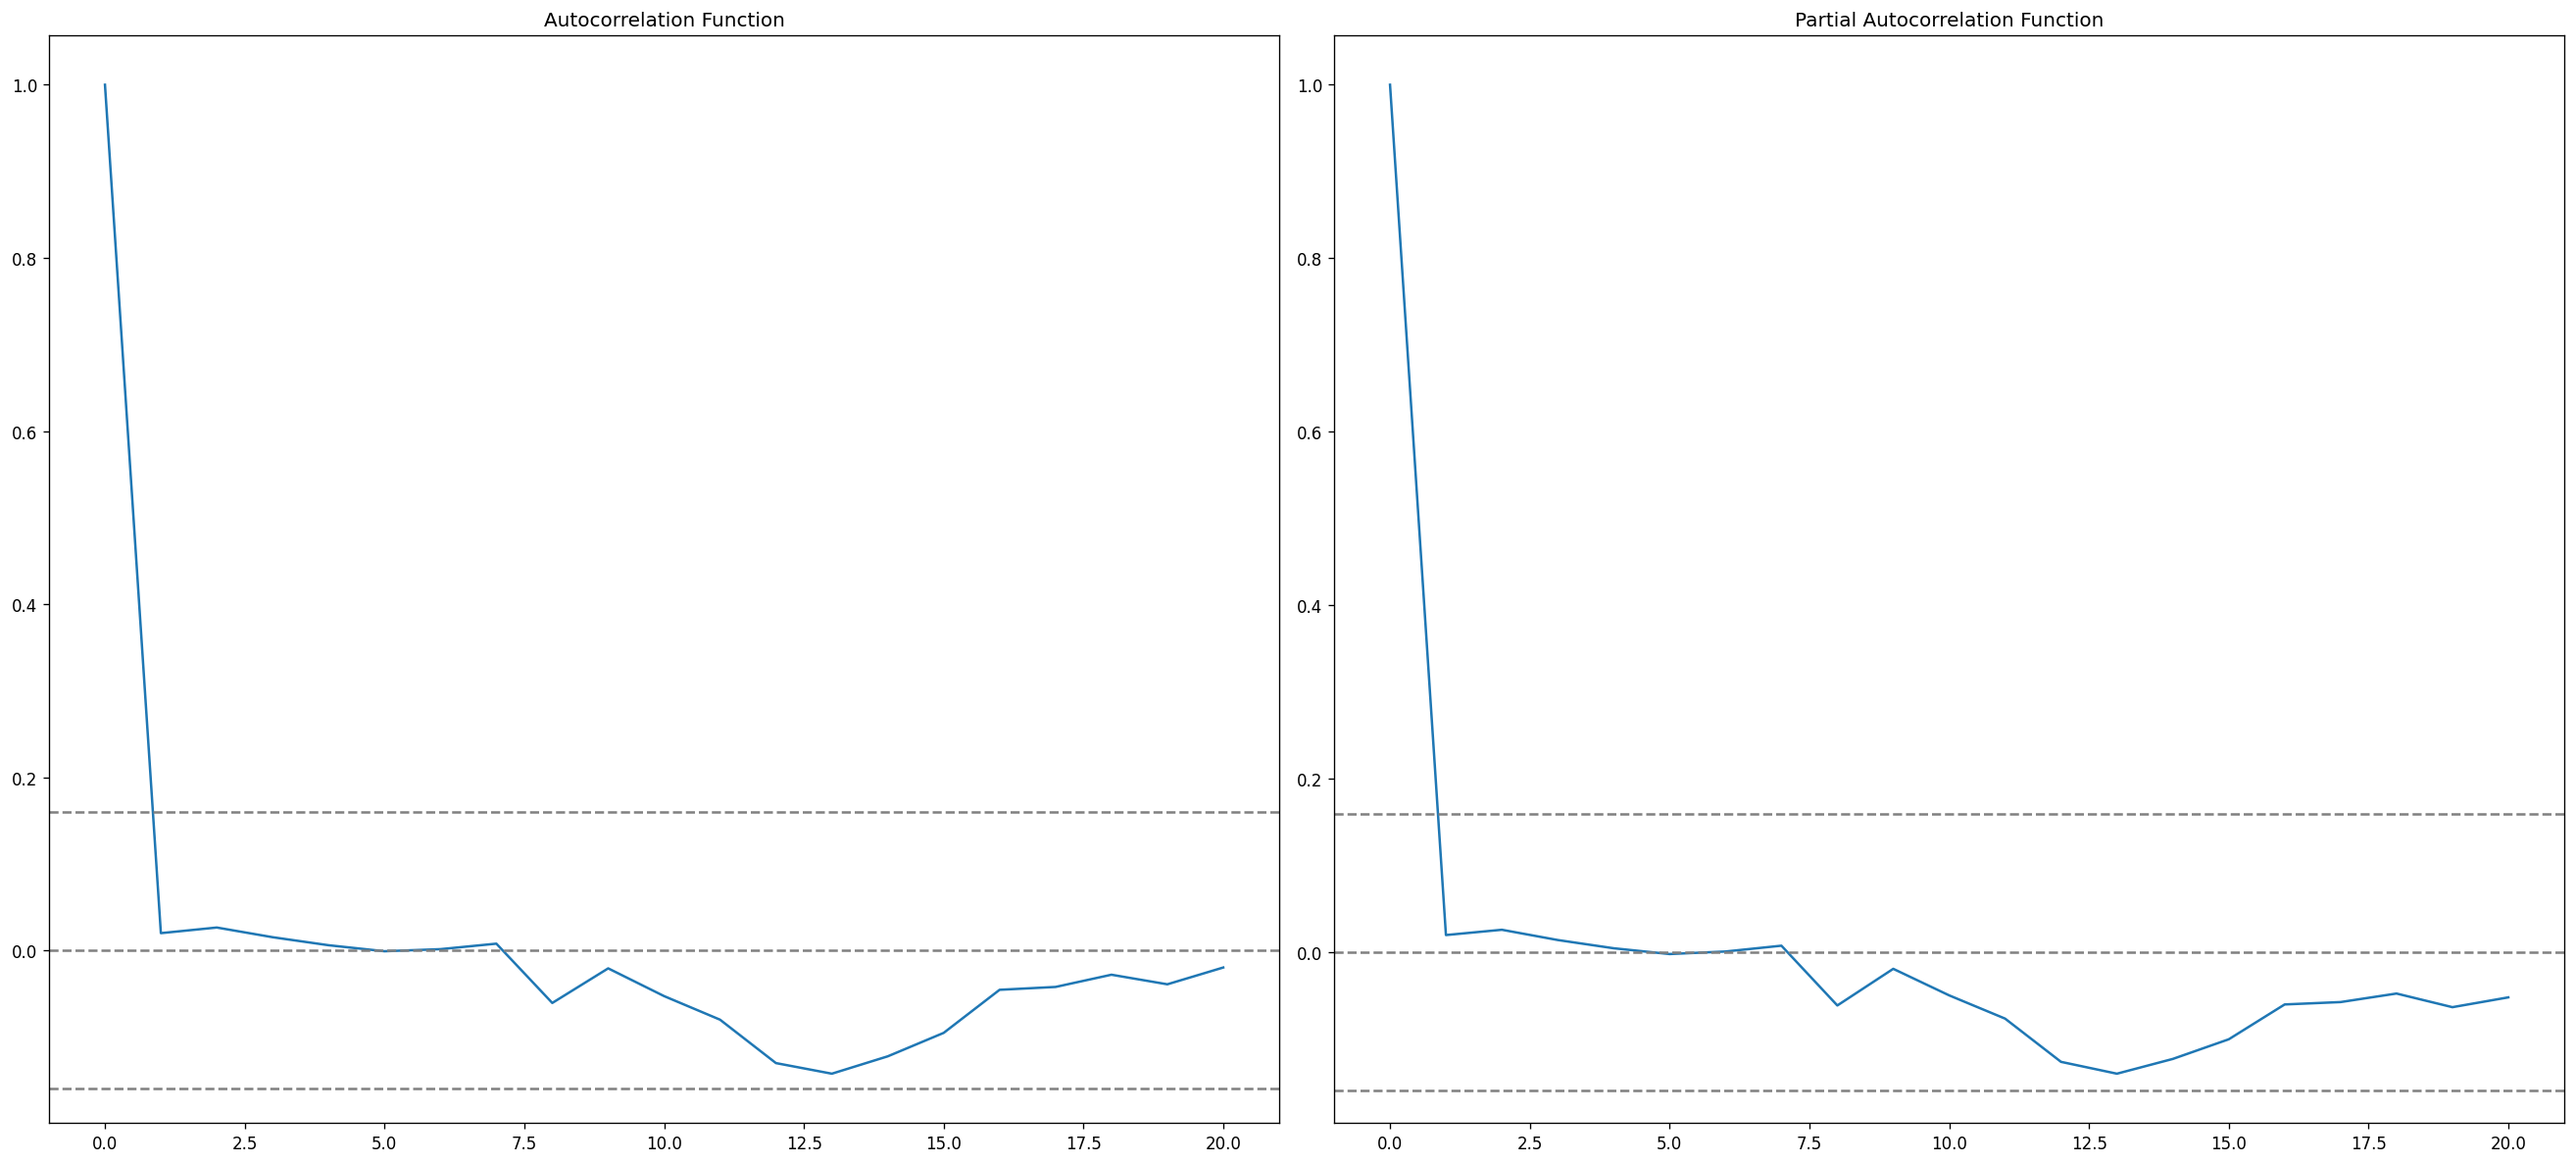

In [21]:
# ACF and PACF 
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(y_deseasonal, nlags=20)
lag_pacf = pacf(y_deseasonal, nlags=20, method='ols')
# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_deseasonal)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_deseasonal)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_deseasonal)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_deseasonal)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Two dotted lines are the confidence interevals. We use these lines to determine the ‘p’ and ‘q’ values
Choosing p: The lag value where the PACF chart crosses the upper confidence interval for the first time which is close to 2. p=2.
Choosing q: The lag value where the ACF chart crosses the upper confidence interval for the first time which is close to 2. q=2.

In [22]:
model = ARIMA(y_deseasonal, order=(2,0,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               seasonal   No. Observations:                  151
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -740.033
Date:                Tue, 17 Jan 2023   AIC                           1492.066
Time:                        07:20:28   BIC                           1510.169
Sample:                    02-02-2020   HQIC                          1499.420
                         - 12-18-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0358      9.998      0.304      0.761     -16.559      22.631
ar.L1          0.7419     21.306      0.035      0.972     -41.016      42.500
ar.L2         -0.1895     16.150     -0.012      0.9

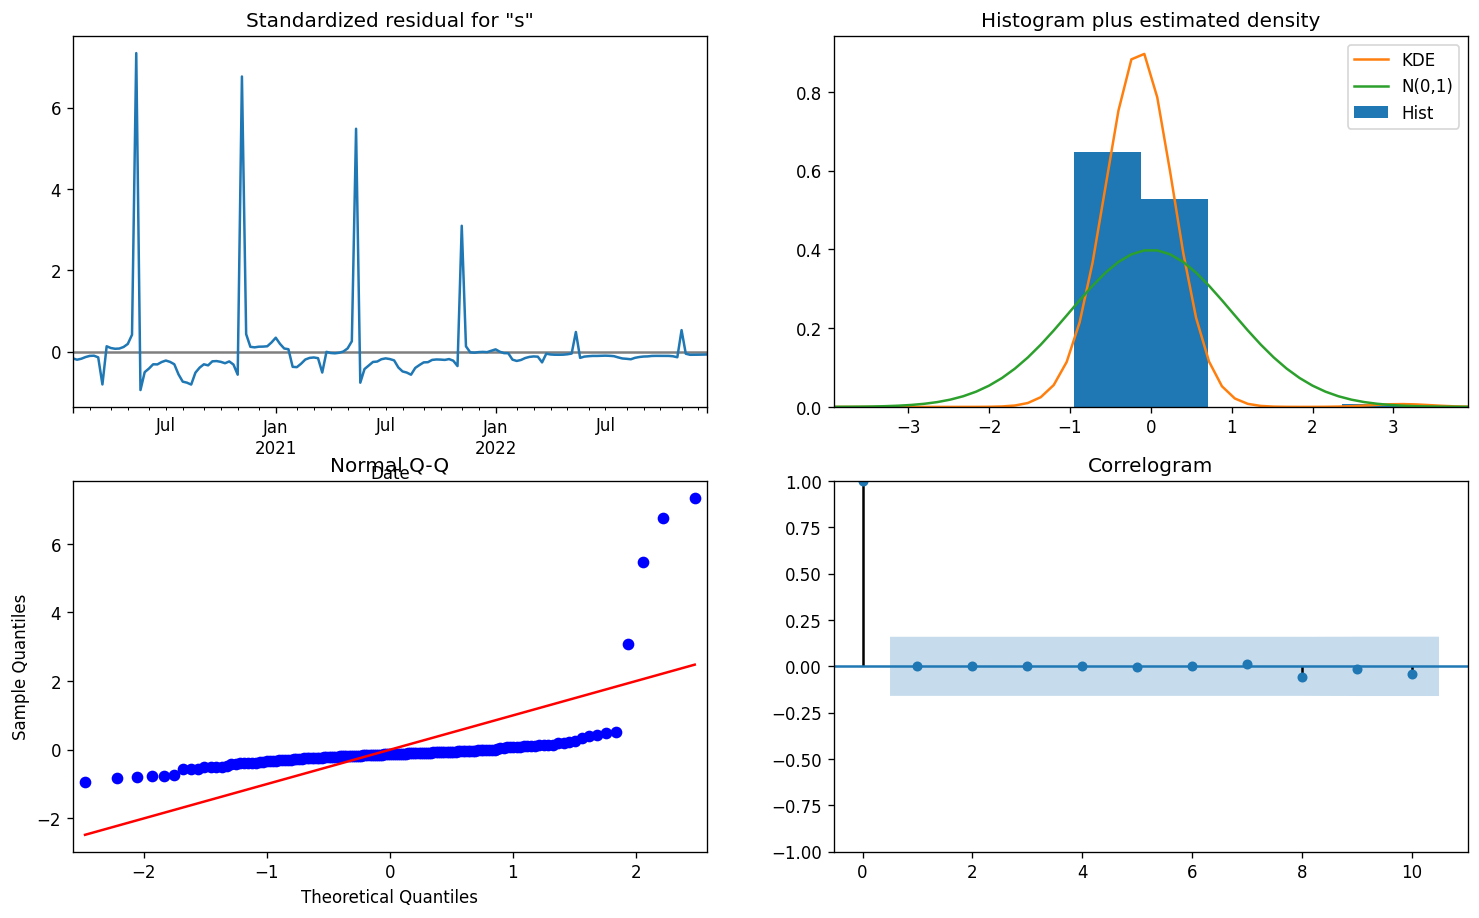

In [23]:
residuals_default = model_fit.plot_diagnostics(figsize=(15, 9))

* One-step ahead forecast

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


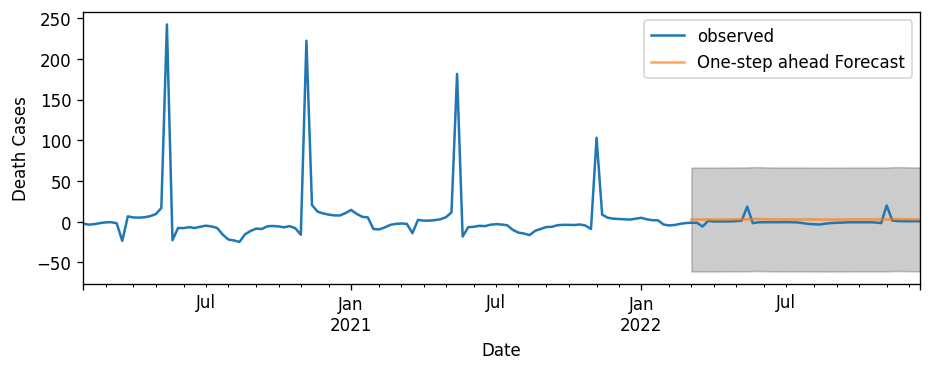

In [24]:
# Validating forecasts
# To help us understand the accuracy of our forecasts, 
# we compare predicted sales to real sales of the time series, and we set forecasts 
# to start at 2022-03-06 to the end of the data.
pred = model_fit.get_prediction(start=pd.to_datetime('2022-03-06'), dynamic=False)
pred_ci = pred.conf_int()
ax = y_deseasonal.loc[:][:].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Death Cases')
plt.legend()
plt.show()
# The line plot is showing the observed values compared to the rolling forecast predictions. 
# Overall, our forecasts slightly differs with the true values, but shows a downward trend starts from the 
# 1st quarter of the year and captured the seasonality toward the end of the year.

* Validating Metrics

In [25]:
# Predicted sales values
y_forecasted = pred.predicted_mean
# actual sales values
y_truth = y_deseasonal.loc['2022-03-06':][:]

In [26]:
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 26.75
The Root Mean Squared Error of our forecasts is 5.17


* Dynamic forecast

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


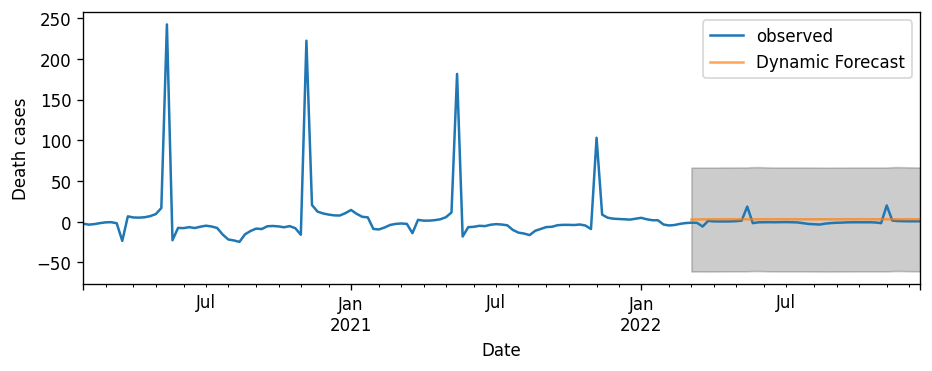

In [27]:
#dynamic=True
pred_dynamic = model_fit.get_prediction(start=pd.to_datetime('2022-03-06'), dynamic=True)
pred_dynamic_ci = pred.conf_int()
ax = y_deseasonal.loc[:][:].plot(label='observed')

pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=.7)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Death cases')
plt.legend();



* Validating metrics

In [28]:
# Predicted sales values
y_forecasted = pred_dynamic.predicted_mean
# actual sales values
y_truth = y_deseasonal.loc['2022-03-06':][:]


In [29]:
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 27.71
The Root Mean Squared Error of our forecasts is 5.26


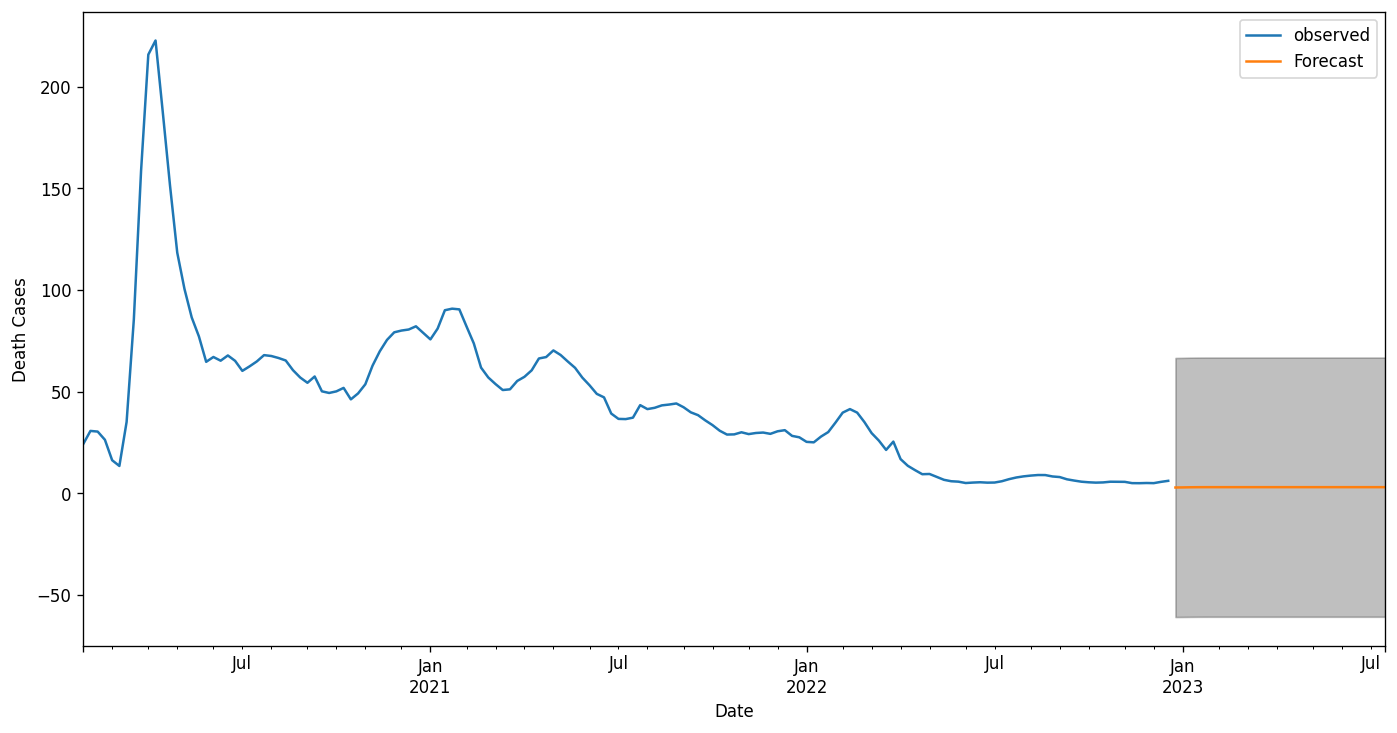

In [30]:
pred_uc = model_fit.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = y.loc['2020-02-02':][:].plot(label='observed', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Death Cases')
plt.legend()
plt.show()

In [31]:
# Produce the forcasted tables 
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
final_table = pm.join(pci.set_index('Date'), on='Date')
final_table

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2022-12-25,2.86939965,-60.86969210,66.60849140
1,2023-01-01,2.91619947,-60.83437706,66.66677599
2,2023-01-08,2.97859690,-60.79294632,66.75014012
3,2023-01-15,3.01602096,-60.76311055,66.79515247
4,2023-01-22,3.03196193,-60.74855274,66.81247659
5,2023-01-29,3.03669695,-60.74394061,66.81733450
6,2023-02-05,3.03718918,-60.74344976,66.81782812
7,2023-02-12,3.03665714,-60.74398331,66.81729758
8,2023-02-19,3.03616914,-60.74447259,66.81681087
9,2023-02-26,3.03590792,-60.74473418,66.81655002


* SARIMA

* p,d,q

In [32]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [33]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [34]:
# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [35]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


* Grid Search

In [36]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
results_params = []
results_aic = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            results_params.append(str(param) +'x'+ str(param_seasonal))
            results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1649.9296370408879
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1349.6616847149603
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1350.9560916232526
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1077.4284850376628
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1322.1081867890948
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1275.5676476340216
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1103.5011169574473
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1078.4555587390203
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1450.566341465295
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1164.1033913898573
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1166.9153966654894
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:915.9379293260449
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1162.6885690935085
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1089.00294273811
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:964.4792553671348
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:917.9357754451868
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1136.4967537034572
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:774.8858672284039

In [37]:
results_params_aic = zip(results_params, results_aic)
results_params_aic

In [38]:
# Sort the feature importances by most important first
results_params_aic = sorted(results_params_aic, key = lambda x: x[1], reverse = False)
results_params_aic[:5]

[('(1, 1, 1)x(1, 1, 1, 12)', 683.978719074992),
 ('(1, 1, 1)x(0, 0, 1, 12)', 692.3552987213948),
 ('(1, 1, 1)x(1, 0, 1, 12)', 694.2312561514889),
 ('(1, 1, 0)x(1, 1, 1, 12)', 694.7480912867878),
 ('(1, 1, 1)x(1, 0, 0, 12)', 697.2128270013786)]

* SARIMA

In [39]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod_default = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1 , 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_default = mod_default.fit()

In [40]:
print(results_default.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Deaths   No. Observations:                  151
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -336.989
Date:                            Tue, 17 Jan 2023   AIC                            683.979
Time:                                    07:20:44   BIC                            698.080
Sample:                                02-02-2020   HQIC                           689.707
                                     - 12-18-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8407      0.047     18.042      0.000       0.749       0.932
ma.L1         -0.2773      0.081   

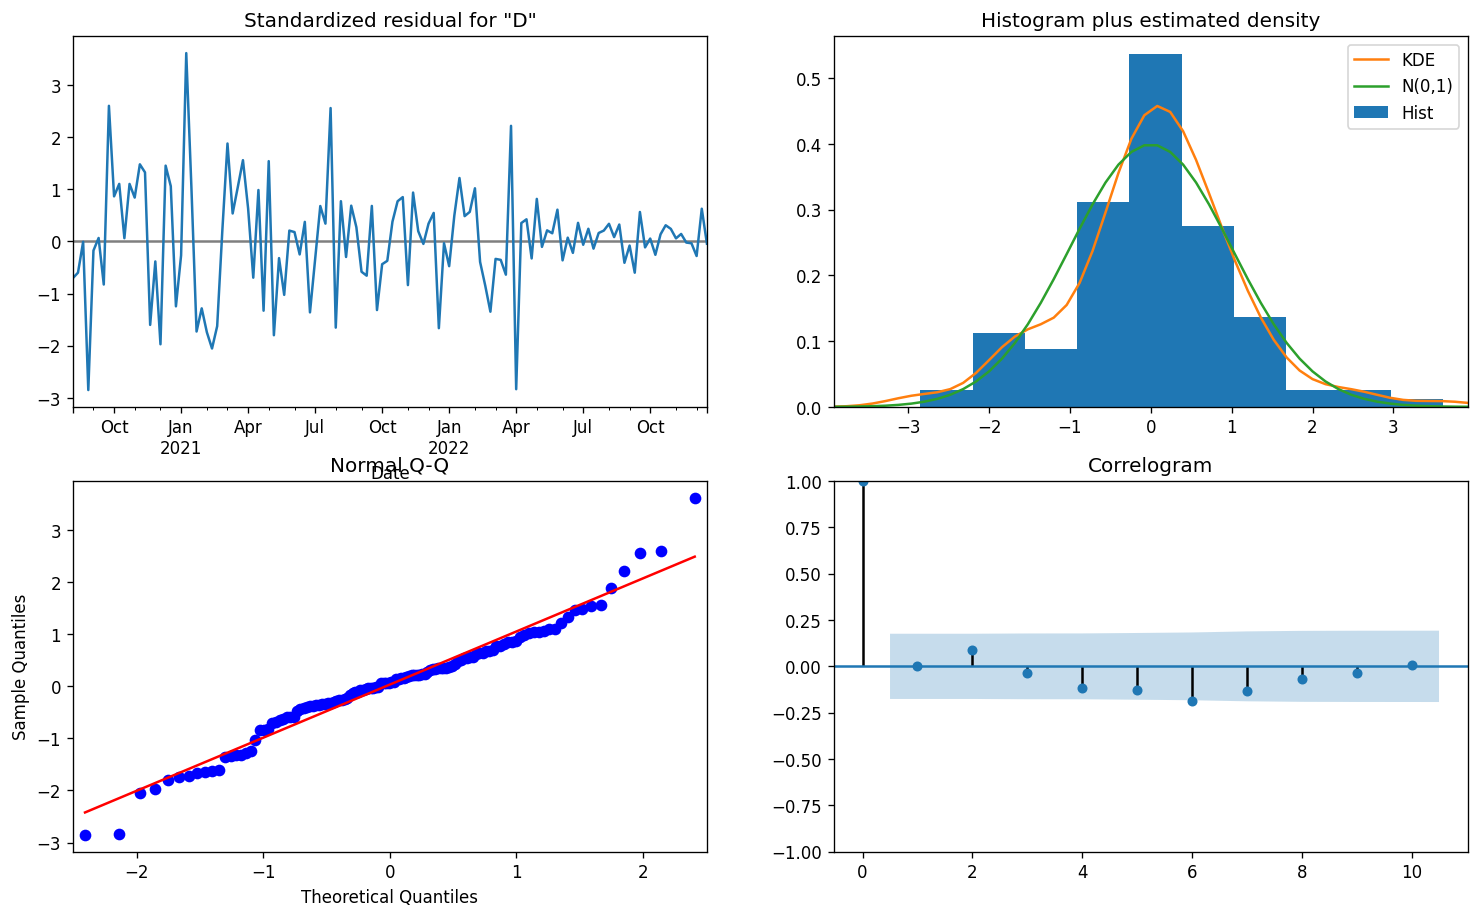

In [41]:
residuals_default = results_default.plot_diagnostics(figsize=(15, 9))

* Validating Forecasts:
We have obtained a model for our time series that can now be used to produce forecasts.

We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts

The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

* One-step ahead forecast

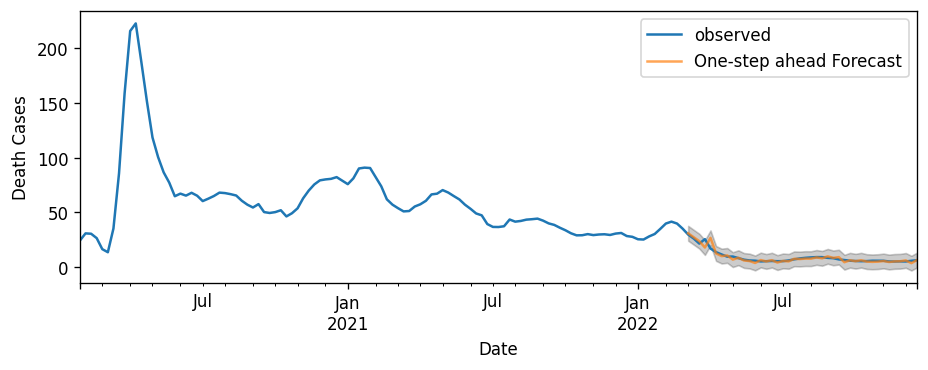

In [42]:
# Validating forecasts
# To help us understand the accuracy of our forecasts, 
# we compare predicted sales to real sales of the time series, and we set forecasts 
# to start at 2022-03-06 to the end of the data.
pred = results_default.get_prediction(start=pd.to_datetime('2022-03-06'), dynamic=False)
pred_ci = pred.conf_int()
ax = y.loc[:][:].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Death Cases')
plt.legend()
plt.show()
# The line plot is showing the observed values compared to the rolling forecast predictions. 
# Overall, our forecasts slightly differs with the true values, but shows a downward trend starts from the 
# 1st quarter of the year and captured the seasonality toward the end of the year.

* Validating metrics

In [43]:
# Predicted sales values
y_forecasted = pred.predicted_mean
# actual sales values
y_truth = y.loc['2022-03-06':][:]

In [44]:
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 4.94
The Root Mean Squared Error of our forecasts is 2.22


* Dynamic forecasts



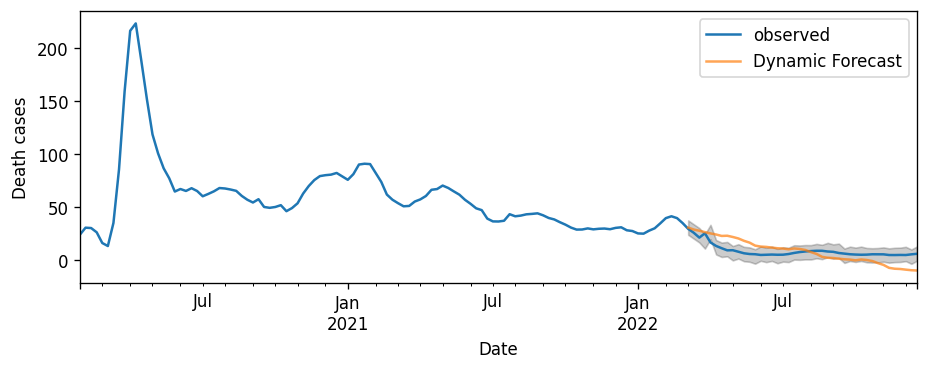

In [45]:
#dynamic=True
pred_dynamic = results.get_prediction(start=pd.to_datetime('2022-03-06'), dynamic=True)
pred_dynamic_ci = pred.conf_int()
ax = y.loc[:][:].plot(label='observed')

pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=.7)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Death cases')
plt.legend();



* Validating metrics

In [46]:
# Predicted sales values
y_forecasted = pred_dynamic.predicted_mean

# actual sales values
y_truth = y.loc['2022-03-06':][:]


In [47]:
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 73.56
The Root Mean Squared Error of our forecasts is 8.58


In [48]:
# In statistics, the mean squared error (MSE) of an estimator measures the average of the 
# squares of the errors — that is, the average squared difference between the estimated values 
# and what is estimated. 

# The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, 
# the closer we are to finding the line of best fit.

# Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily death cases 
# in the test set within 30.36 of the real cases. 

* Future forecast using SARIMA model: Producing and Visualizing future Forecasts
The get_forecast() attribute of our time series object can compute forecasted values for a specified number of steps ahead.

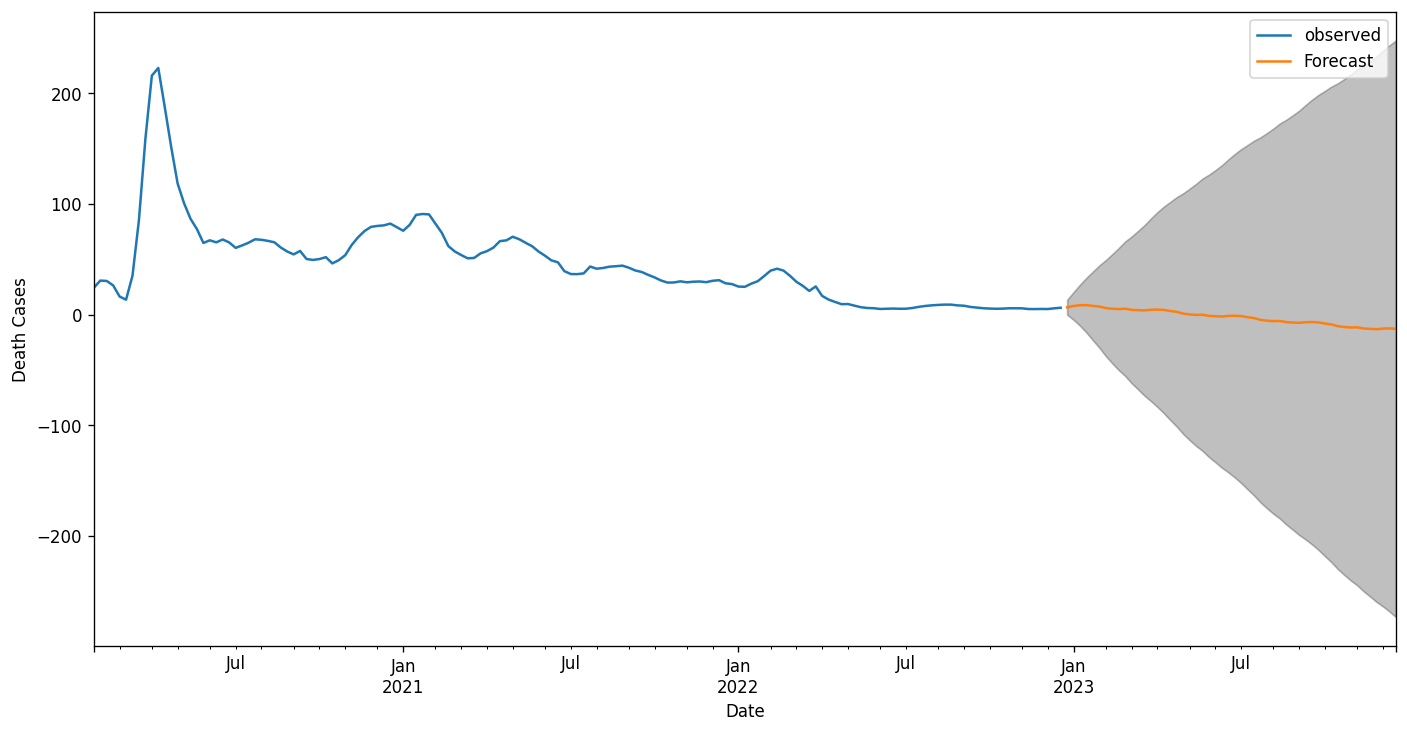

In [49]:
pred_uc = results_default.get_forecast(steps=52)
pred_ci = pred_uc.conf_int()
ax = y.loc['2020-02-02':][:].plot(label='observed', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Death Cases')
plt.legend()
plt.show()

In [50]:
# Produce the forcasted tables 
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
final_table = pm.join(pci.set_index('Date'), on='Date')
final_table

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2022-12-25,6.58357357,-0.15995341,13.32710055
1,2023-01-01,7.78996097,-4.72535024,20.30527218
2,2023-01-08,8.46232832,-10.12124351,27.04590016
3,2023-01-15,8.51624790,-16.28399693,33.31649274
4,2023-01-22,7.83261517,-23.21553429,38.88076462
5,2023-01-29,7.26521638,-29.98257958,44.51301233
6,2023-02-05,5.86400263,-37.48245584,49.21046111
7,2023-02-12,5.27500317,-44.03726719,54.58727353
8,2023-02-19,4.99259605,-50.13230599,60.11749809
9,2023-02-26,5.29612437,-55.47708938,66.06933812
